# Download CMAQ gridded-comparison

In [3]:
import requests
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
# programatically download CMAQ PM2.5 gridded estimates
# https://www.epa.gov/hesc/rsig-related-downloadable-data-files
years = list(range(2010,2021+1))
if not os.path.exists("CMAQ"):
    os.mkdir("CMAQ")
for year in years:
    print(year)
    if not os.path.exists(f"CMAQ/ds_input_cmaq_pm25_{year}.zip"):
        url = f"https://ofmpub.epa.gov/rsig/rsigserver?data/FAQSD/inputs/ds_input_cmaq_pm25_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"CMAQ/ds_input_cmaq_pm25_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)
        time.sleep(2)
    

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [3]:
year = 2010
cmaq2010 = pd.read_csv(f"CMAQ/ds_input_cmaq_pm25_{year}.zip")

In [4]:
display(cmaq2010.shape)
display(cmaq2010.columns)

(50092965, 7)

Index(['Domain', 'Col', 'Row', 'Lon', 'Lat', 'Date', 'Conc'], dtype='object')

In [5]:
display(len(np.unique(cmaq2010['Col'])))
display(459*109135)
display(len(np.unique(cmaq2010['Row'])))
display(299*167535)
display(50092965/137241)

459

50092965

299

50092965

365.0

In [6]:
import numpy as np

# make grouping matrix for CMAQ, 459 x 299 grid -> 92 x 60 (group squares 5x5, with 5x4 and 4x5 rects at the ends)
rows, cols = 459, 299
side_length = 5

group_matrix = np.zeros((rows, cols), dtype=int)

group_id = 1
for i in range(0, rows, side_length):
    for j in range(0, cols, side_length):
        group_matrix[i:i+side_length, j:j+side_length] = group_id
        group_id += 1

display(group_matrix)
flatGroup = group_matrix.flatten()
flatGroup.shape

array([[   1,    1,    1, ...,   60,   60,   60],
       [   1,    1,    1, ...,   60,   60,   60],
       [   1,    1,    1, ...,   60,   60,   60],
       ...,
       [5461, 5461, 5461, ..., 5520, 5520, 5520],
       [5461, 5461, 5461, ..., 5520, 5520, 5520],
       [5461, 5461, 5461, ..., 5520, 5520, 5520]])

(137241,)

In [7]:
groupCol = np.tile(flatGroup,365)

In [8]:
cmaq2010['group'] = groupCol

In [14]:
import geopandas as gpd

# Convert DataFrames to GeoDataFrames
def to_gdf(df, lat_col='latitude', lon_col='longitude'):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[lon_col], df[lat_col]), crs="EPSG:4326")

In [15]:
cmaqDrop = cmaq2010.drop('Domain', axis=1).groupby(['group', 'Date'], as_index=False).mean()

In [16]:
cmaqDrop.shape

(2014800, 7)

In [17]:
cmaqDropgeo = to_gdf(cmaqDrop, 'Lat', 'Lon')

<Axes: >

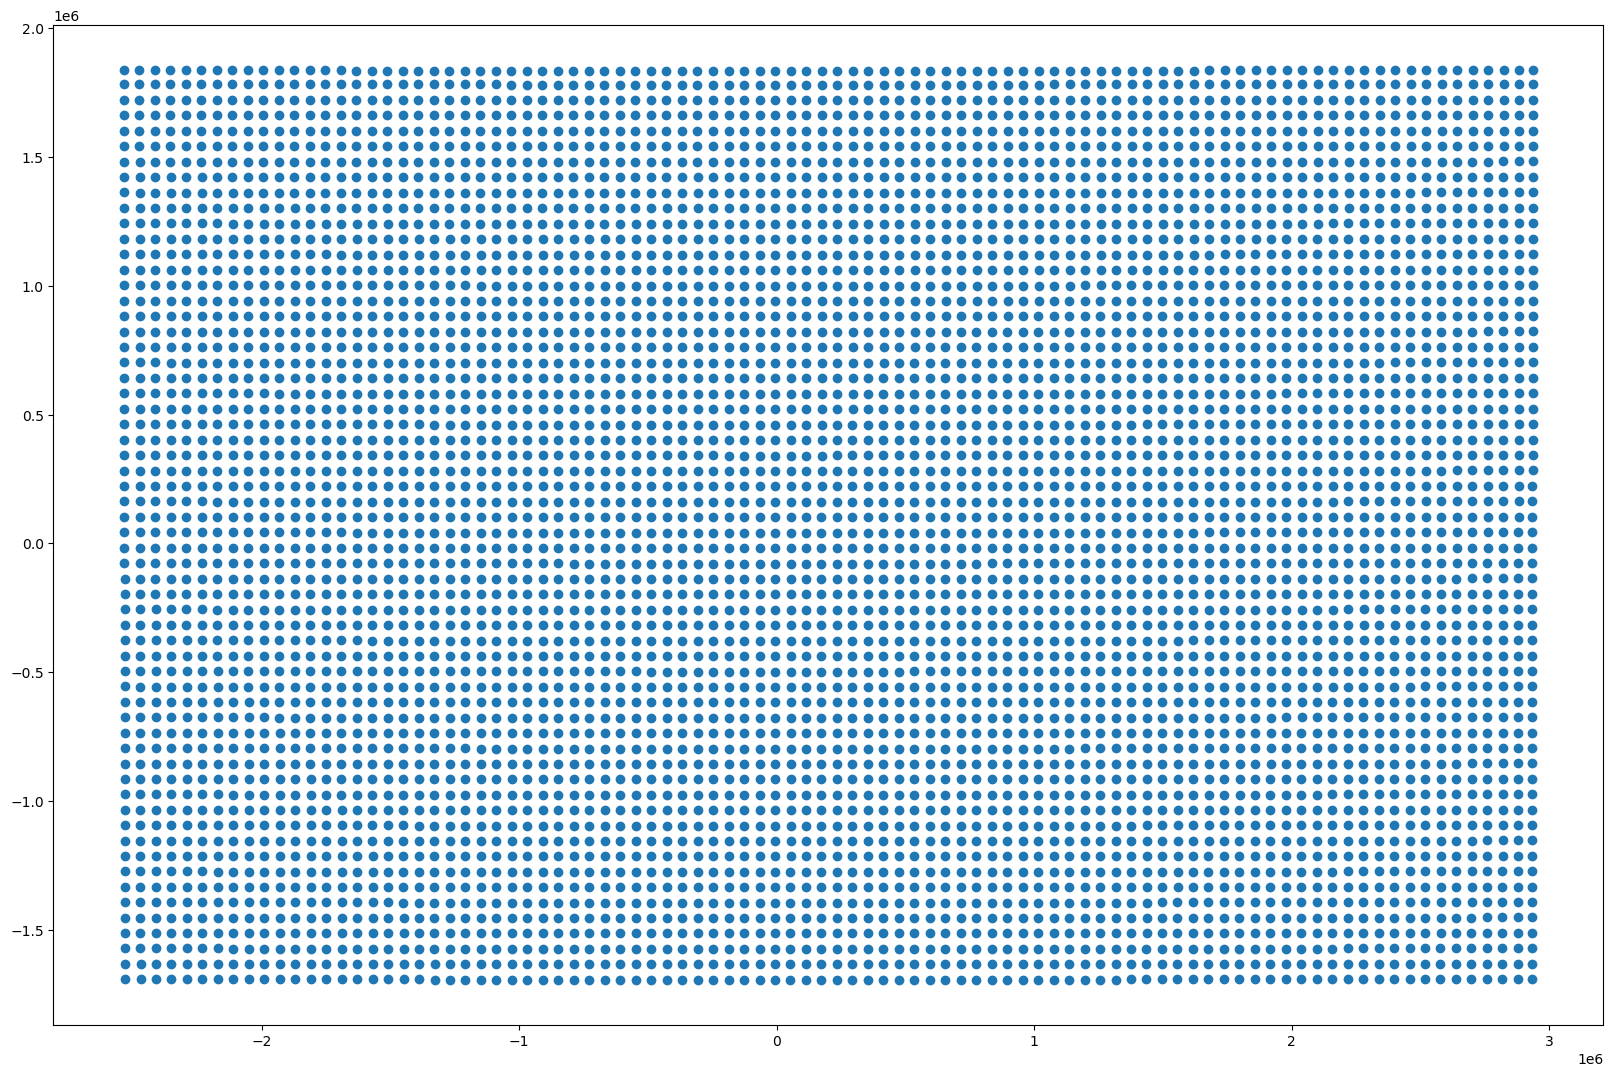

In [19]:
# taken from https://ofmpub.epa.gov/rsig/rsigserver?data/FAQSD/docs/2020_DS_Annual_Report.pdf
# Lambert Conformal Projection with true latitudes at 33 and 45 N, coordinate center 97 W, 40 N
cmaqProj = (
    "+proj=lcc "
    "+lat_1=33 +lat_2=45 "        # standard parallels
    "+lat_0=40 "                  # latitude of origin
    "+lon_0=-97 "                 # central meridian
    "+x_0=0 +y_0=0 "              # false easting/northing
    "+datum=WGS84 +units=m +no_defs"
)

# project points to the CMAQ grid specified in the documentation
reproj = cmaqDropgeo.to_crs(cmaqProj)
reproj.drop_duplicates(('Lat', 'Lon')).plot(figsize=(20, 20))

In [20]:
reproj.drop_duplicates(('Lat', 'Lon')).explore(column="group", categorical=True)

(-2000000.0, 2000000.0)

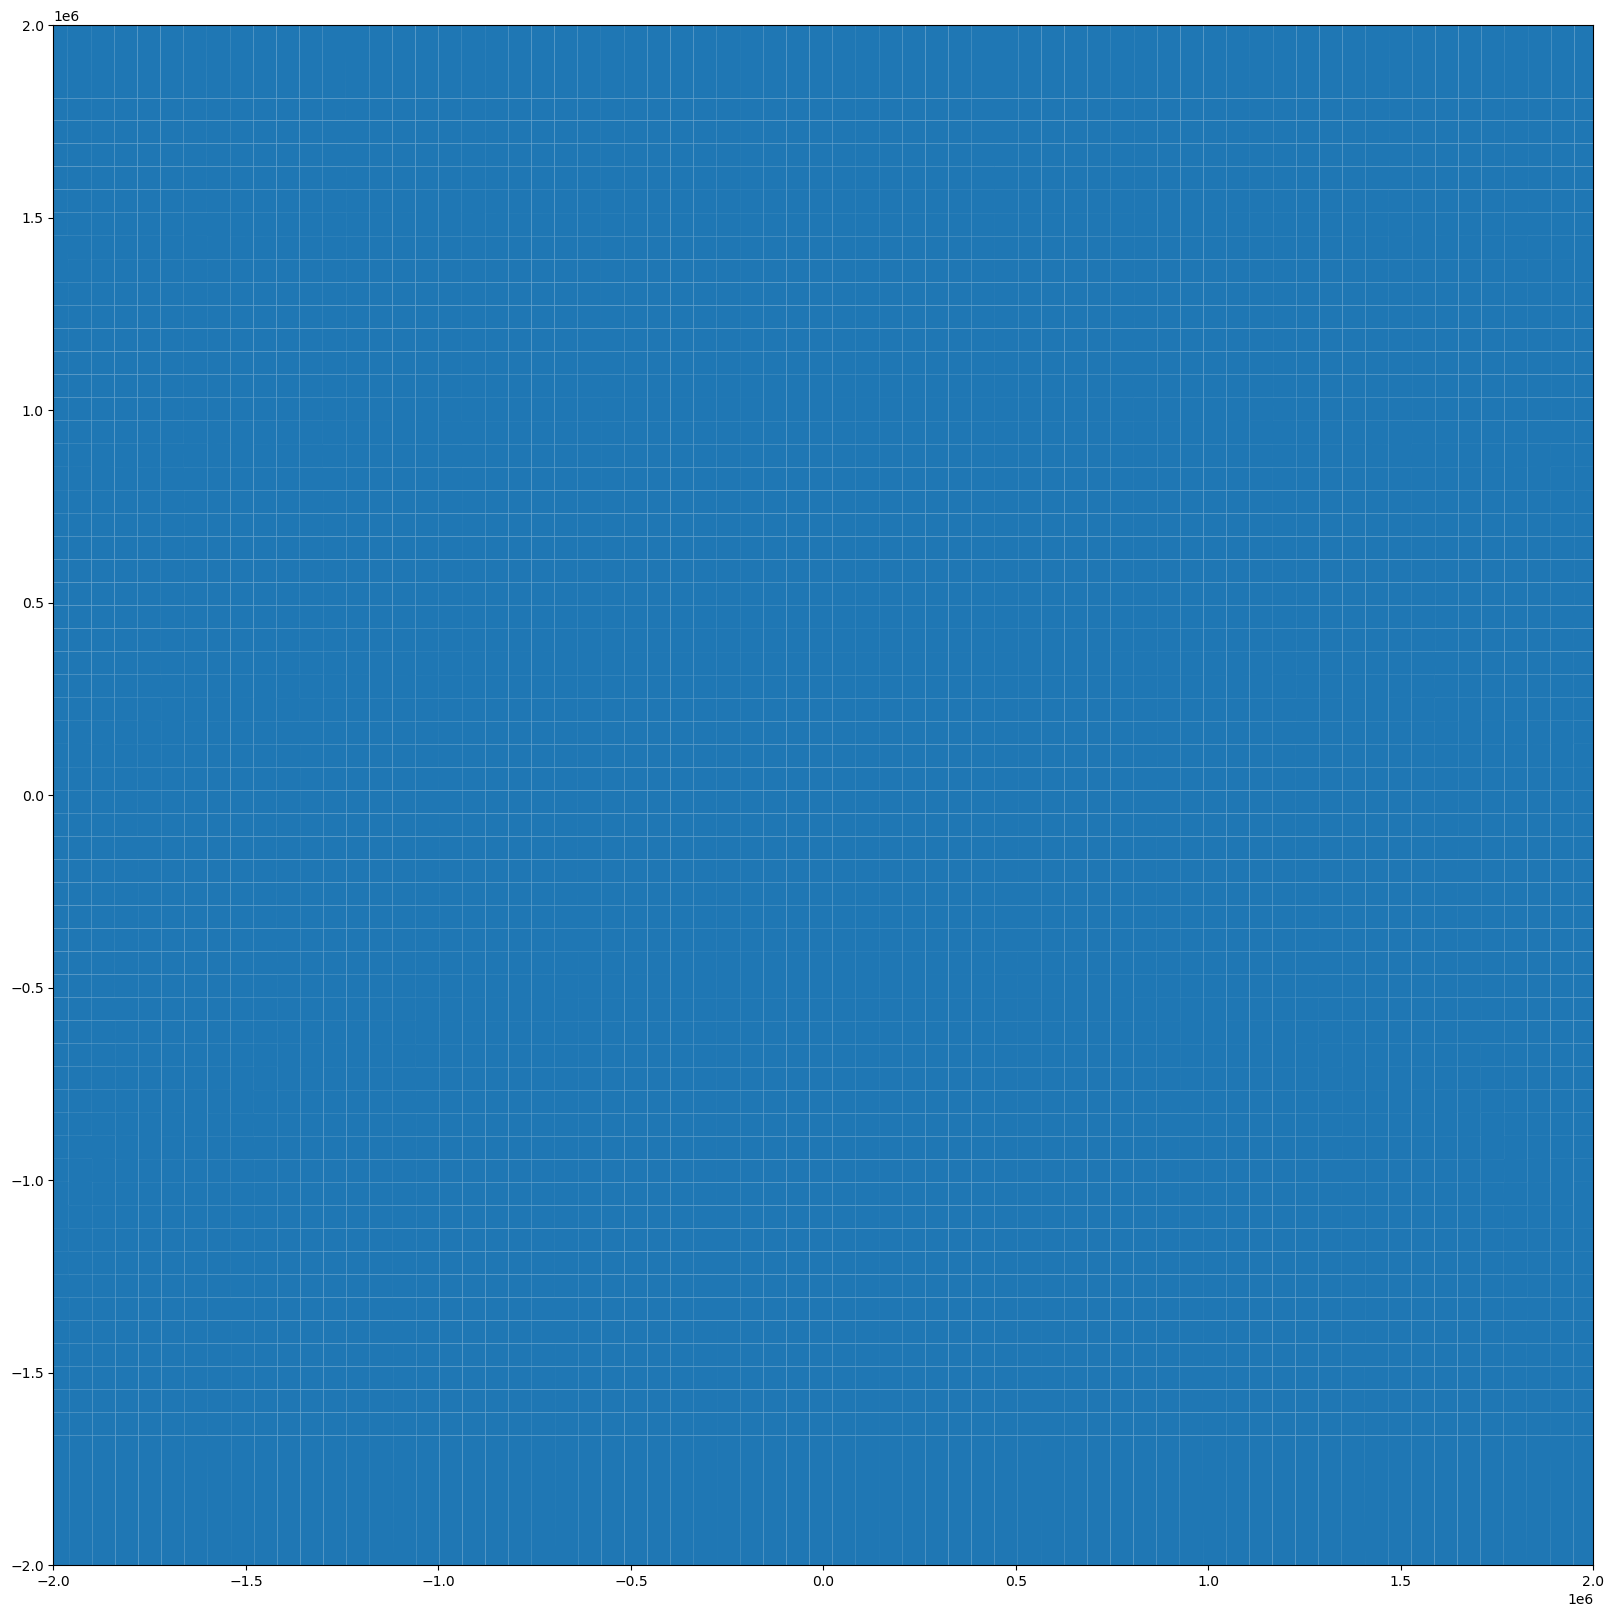

In [21]:
import matplotlib.pyplot as plt
voronoi = reproj.voronoi_polygons()
voronoi.plot(figsize=(20, 20))
plt.xlim(-2e6,2e6)
plt.ylim(-2e6, 2e6)

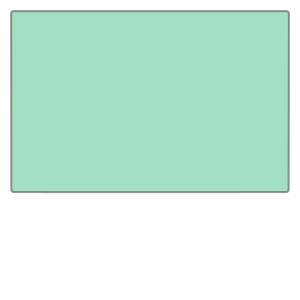

In [80]:
mask = reproj.drop_duplicates(('Lat', 'Lon')).union_all().convex_hull.buffer(0.05e6)
mask

In [82]:
int = voronoi.intersection(mask)
int.explore()

In [85]:
cmaqReprojgeoVoronoi = gpd.sjoin(reproj, gpd.GeoDataFrame(geometry=voronoi), how = 'left')

In [88]:
cmaqDropgeoVoronoi

group        Date    Col    Row         Lon        Lat      Conc  \
0            1  2010-01-01    3.0    3.0 -120.866220  21.875753  0.892091   
1            1  2010-01-02    3.0    3.0 -120.866220  21.875753  1.688396   
2            1  2010-01-03    3.0    3.0 -120.866220  21.875753  1.338089   
3            1  2010-01-04    3.0    3.0 -120.866220  21.875753  2.004181   
4            1  2010-01-05    3.0    3.0 -120.866220  21.875753  1.939387   
...        ...         ...    ...    ...         ...        ...       ...   
2014795   5520  2010-12-27  457.5  297.5  -54.903926  50.284376  1.196300   
2014796   5520  2010-12-28  457.5  297.5  -54.903926  50.284376  1.014002   
2014797   5520  2010-12-29  457.5  297.5  -54.903926  50.284376  1.889826   
2014798   5520  2010-12-30  457.5  297.5  -54.903926  50.284376  1.885335   
2014799   5520  2010-12-31  457.5  297.5  -54.903926  50.284376  1.292051   

                            geometry  index_right  
0        POINT (-2.53e+06 -1.69e+06)           90  
1        POINT (-2.53e+06 -1.69e+06)           90  
2        POINT (-2.53e+06 -1.69e+06)           90  
3        POINT (-2.53e+06 -1.69e+06)           90  
4        POINT (-2.53e+06 -1.69e+06)           90  
...                              ...          ...  
2014795    POINT (2.94e+06 1.84e+06)         5519  
2014796    POINT (2.94e+06 1.84e+06)         5519  
2014797    POINT (2.94e+06 1.84e+06)         5519  
2014798    POINT (2.94e+06 1.84e+06)         5519  
2014799    POINT (2.94e+06 1.84e+06)         5519  

[2014800 rows x 9 columns]

### Find weather station PM2.5 measurements

In [89]:
# programatically download both federally-regulated and non-federally-regulated daily PM2.5 information
# https://aqs.epa.gov/aqsweb/airdata/download_files.html#Raw
years = list(range(2010,2021+1))
if not os.path.exists("PM2.5"):
    os.mkdir("PM2.5")
for year in years:
    print(year)
    if not os.path.exists(f"PM2.5/daily_88101_{year}.zip"):
        url = f"https://aqs.epa.gov/aqsweb/airdata/daily_88101_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"PM2.5/daily_88101_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)

    if not os.path.exists(f"PM2.5/daily_88502_{year}.zip"):
        url = f"https://aqs.epa.gov/aqsweb/airdata/daily_88502_{year}.zip"
        response = requests.get(url, stream=True)
        with open(f"PM2.5/daily_88502_{year}.zip", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)
        time.sleep(2)
    

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


In [92]:
# federally-regulated sensors
PM2010_88101 = pd.read_csv('PM2.5/daily_88101_2010.zip')
PM2010_88101.describe()

State Code    County Code       Site Num  Parameter Code  \
count  230028.000000  230028.000000  230028.000000        230028.0   
mean       25.730224      74.355939     678.073887         88101.0   
std        16.174648      87.860608    1552.397756             0.0   
min         1.000000       1.000000       1.000000         88101.0   
25%        12.000000      21.000000       6.000000         88101.0   
50%        24.000000      57.000000      19.000000         88101.0   
75%        40.000000      99.000000    1001.000000         88101.0   
max        78.000000     810.000000    9997.000000         88101.0   

                 POC       Latitude      Longitude  Observation Count  \
count  230028.000000  230028.000000  230028.000000      230028.000000   
mean        1.858722      38.567237     -96.375154           5.911054   
std         1.014308       6.455165      20.827498           9.313001   
min         1.000000      17.712474    -158.088613           1.000000   
25%         1.000000      35.356615    -112.118210           1.000000   
50%         1.000000      39.551300     -87.913504           1.000000   
75%         3.000000      41.707570     -80.580717           1.000000   
max         9.000000      64.845690     -64.784868          24.000000   

       Observation Percent  Arithmetic Mean  1st Max Value   1st Max Hour  \
count        230028.000000    230028.000000  230028.000000  230028.000000   
mean             99.943316        10.020274      12.239993       2.570239   
std              12.734653         6.677099      11.019930       5.982236   
min               4.000000        -5.000000      -4.300000       0.000000   
25%             100.000000         5.375000       6.000000       0.000000   
50%             100.000000         8.500000       9.700000       0.000000   
75%             100.000000        13.100000      15.500000       0.000000   
max             400.000000       195.000000     886.500000      23.000000   

                 AQI    Method Code  
count  179303.000000  230028.000000  
mean       45.534603     147.721843  
std        19.544733      23.996032  
min         0.000000     116.000000  
25%        31.000000     118.000000  
50%        47.000000     145.000000  
75%        58.000000     170.000000  
max       270.000000     236.000000

In [99]:
# non-federally regulated sensors
PM2010_88502 = pd.read_csv('PM2.5/daily_88502_2010.zip')
PM2010_88502.describe()

/tmp/ipykernel_24133/2014225991.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  PM2010_88502 = pd.read_csv('PM2.5/daily_88502_2010.zip')


State Code    County Code       Site Num  Parameter Code  \
count  358318.000000  358318.000000  358318.000000        358318.0   
mean       30.898409      76.210617     822.854972         88502.0   
std        15.652524      79.793182    1894.886011             0.0   
min         1.000000       1.000000       1.000000         88502.0   
25%        17.000000      29.000000       7.000000         88502.0   
50%        35.000000      57.000000      22.000000         88502.0   
75%        42.000000     101.000000    1002.000000         88502.0   
max        78.000000     510.000000    9997.000000         88502.0   

                 POC       Latitude      Longitude  Pollutant Standard  \
count  358318.000000  358318.000000  358318.000000                 0.0   
mean        2.994907      38.536041     -97.792728                 NaN   
std         0.868182       6.293628      17.779379                 NaN   
min         1.000000      18.334399    -160.508331                 NaN   
25%         3.000000      33.676490    -117.330980                 NaN   
50%         3.000000      39.154000     -94.167468                 NaN   
75%         3.000000      43.123704     -82.619167                 NaN   
max        12.000000      66.930930     -64.795972                 NaN   

       Observation Count  Observation Percent  Arithmetic Mean  1st Max Value  \
count      358318.000000        358318.000000    358318.000000  358318.000000   
mean           11.278111            99.224122         9.035660      13.082529   
std            11.321170             5.422669         6.229058      11.935844   
min             1.000000             4.000000        -7.000000      -7.000000   
25%             1.000000           100.000000         4.682609       6.000000   
50%             1.000000           100.000000         7.700000      10.300000   
75%            24.000000           100.000000        11.900000      17.000000   
max            24.000000           100.000000       114.087500     997.000000   

        1st Max Hour            AQI    Method Code  
count  358318.000000  195264.000000  358318.000000  
mean       15.809669      41.235799     713.797744  
std         8.941324      20.314123      98.360287  
min         0.000000       0.000000     118.000000  
25%         7.000000      25.000000     702.000000  
50%        22.000000      42.000000     715.000000  
75%        23.000000      56.000000     760.000000  
max        23.000000     192.000000     810.000000

### Find weather station wind measurements

In [4]:
# download bulk meteostat data
if not os.path.exists("meteostat/bulk_data_full.json.gz"):
    url = "https://bulk.meteostat.net/v2/stations/full.json.gz"
    response = requests.get(url, stream=True)
    if not os.path.exists("meteostat"):
        os.mkdir("meteostat")
        with open("meteostat/bulk_data_full.json.gz", mode="wb") as file:
            for chunk in response.iter_content(chunk_size=10 * 1024):
                file.write(chunk)


In [5]:
import json
import gzip

with gzip.open('meteostat/bulk_data_full.json.gz', 'r') as fin:
    full = json.loads(fin.read().decode('utf-8'))
usStations = [x for x in full if x["country"] == "US"]
display(len(usStations))
display(usStations[0])

2935

{'id': '04AEH',
 'name': {'en': 'Norwich'},
 'country': 'US',
 'region': 'NY',
 'identifiers': {'national': None, 'wmo': None, 'icao': 'KOIC'},
 'location': {'latitude': 42.5665, 'longitude': -75.5242, 'elevation': 312},
 'timezone': 'America/New_York',
 'inventory': {'model': {'start': '2022-04-24', 'end': '2025-04-23'},
  'hourly': {'start': '2022-04-23', 'end': '2025-04-14'},
  'daily': {'start': '2022-04-23', 'end': '2022-04-26'},
  'monthly': {'start': None, 'end': None},
  'normals': {'start': None, 'end': None}}}

In [7]:
from datetime import datetime

# filter stations to only stations that have at least some data between 2010 and 2021
start_date = datetime.strptime("2010-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2021-12-31", "%Y-%m-%d")
filteredStations = [station for station in usStations if \
 (station['inventory']['daily']['start'] is not None and \
  datetime.strptime(station['inventory']['daily']['start'], "%Y-%m-%d") < end_date \
  and datetime.strptime(station['inventory']['daily']['end'], "%Y-%m-%d") > start_date)]
len(filteredStations)

2303

In [43]:
ids = [x['id'] for x in filteredStations]
ids[0:3]

['69007', '69015', '69019']

In [33]:
if not os.path.exists("meteostat/daily_wind_station_data_2010-2021.csv.gz"):
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Import Meteostat library and dependencies
    from datetime import datetime
    from meteostat import Daily
    
    # Set time period
    start = datetime(2010, 1, 1)
    end = datetime(2021, 12, 31)
    
    # Get daily data
    stationData = Daily(ids, start, end)
    stationData = data.fetch()

    # remove rows where no wind was collected
    stationData[~stationData['wdir'].isna()].to_csv("meteostat/daily_wind_station_data_2010-2021.csv.gz")

# if the file already exists, just read from the csv. this also changes the index in the original table
# dtype needs to be specified otherwise the first numeric entries are numbers and the rest are strings. they should all be strings
stationData = pd.read_csv("meteostat/daily_wind_station_data_2010-2021.csv.gz", dtype={'station': 'string'})

In [35]:
stationLocs = pd.DataFrame([(x['id'], x['location']['latitude'], x['location']['longitude']) for x in filteredStations], columns = ('station', 'latitude', 'longitude'))

In [44]:
stationLocs.iloc[0:3]

station  latitude  longitude
0   69007   36.6815  -121.7617
1   69015   34.2962  -116.1622
2   69019   32.4198   -99.8554

In [42]:
# merge the lat/long locations back into the station data
stationMerged = stationData.merge(stationLocs, on='station', how='left')
display(stationMerged.iloc[0:3])
# check to make sure all stations got the lat/long
display(any(stationMerged['latitude'].isna()))
display(any(stationMerged['longitude'].isna()))

station        time  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt  \
0   69007  2021-01-02   8.6   5.0  12.0   2.2   NaN   43.0   5.9   NaN   
1   69007  2021-01-03  10.5   9.0  15.0   1.0   NaN   74.0   5.6   NaN   
2   69007  2021-01-04   9.7   5.0  15.0   2.2   NaN  173.0  10.2   NaN   

     pres  tsun  latitude  longitude  
0  1024.2   NaN   36.6815  -121.7617  
1  1024.0   NaN   36.6815  -121.7617  
2  1022.2   NaN   36.6815  -121.7617

False

False

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# radius for matching
radius = 100

# Convert DataFrames to GeoDataFrames
def to_gdf(df, lat_col='latitude', lon_col='longitude'):
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    return gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# add geometry column for long/lat comparisons
PM2010geo = to_gdf(PM2010, 'Latitude', 'Longitude')
PM2010_88502geo = to_gdf(PM2010_88502, 'Latitude', 'Longitude')